In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cd "/content/drive/MyDrive/MLSP_Project/Asish kumar Mishra/Work/MLSP_Exp_2"

In [5]:
!pip install textdistance

# Importing Libraries

In [6]:
import os
import sys
import pdb
import six
import random
import lmdb
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import math
from collections import OrderedDict
from itertools import chain
import logging


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import sampler
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from torch.nn.utils.clip_grad import clip_grad_norm_
from torch.utils.data import random_split

from utils import AverageMeter, Eval, OCRLabelConverter
from utils import EarlyStopping, gmkdir
from optimizer import STLR
from utils import gaussian
from torchvision.utils import make_grid
from tqdm import *
from tqdm import tqdm_notebook

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# Choosing the device you want : cpu , gpu or tpu

device_type = input("Please choose the type of device you want to use : ")
if device_type=="cpu":
    device = torch.device("cpu")
elif device_type=="gpu":
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
elif device_type=="tpu":
    import torch_xla
    import torch_xla.core.xla_model as xm
    device = xm.xla_device()

print("\nYou are using ", device)

Please choose the type of device you want to use : gpu

You are using  cuda:0


# Data Loading and Preprocessing

## Data Transformer

In [ ]:
class SynthDataset(Dataset):
    def __init__(self, opt):
        super(SynthDataset, self).__init__()
        self.path = os.path.join(opt['path'], opt['imgdir'])
        self.images = os.listdir(self.path)
        self.nSamples = len(self.images)
        f = lambda x: os.path.join(self.path, x)
        self.imagepaths = list(map(f, self.images))
       	transform_list =  [transforms.Resize((32)),
                           transforms.Grayscale(1),
                            transforms.ToTensor(), 
                            transforms.Normalize((0.5,), (0.5,))]
        self.transform = transforms.Compose(transform_list)
        self.collate_fn = SynthCollator()

    def __len__(self):
        return self.nSamples

    def __getitem__(self, index):
        assert index <= len(self), 'index range error'
        imagepath = self.imagepaths[index]
        imagefile = os.path.basename(imagepath)
        img = Image.open(imagepath)
        if self.transform is not None:
            img = self.transform(img)
        item = {'img': img, 'idx':index}
        item['label'] = imagefile.split('_')[1]
        return item

## Data Collator

In [ ]:
class SynthCollator(object):
    
    def __call__(self, batch):
        width = [item['img'].shape[2] for item in batch]
        height = 32
        indexes = [item['idx'] for item in batch]
        imgs = torch.ones([len(batch), batch[0]['img'].shape[0], height, 
                           max(width)], dtype=torch.float32)
        for idx, item in enumerate(batch):
            try:
                imgs[idx, :, 0:item['img'].shape[1], 0:item['img'].shape[2]] = item['img']
            except:
                print(imgs.shape)
        item = {'img': imgs, 'idx':indexes}
        if 'label' in batch[0].keys():
            labels = [item['label'] for item in batch]
            item['label'] = labels
        return item

# CRNN Model

In [ ]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()
        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)
    def forward(self, input):
        self.rnn.flatten_parameters()
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)
        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)
        return output

class CRNN(nn.Module):

    def __init__(self, opt, leakyRelu=False):
        super(CRNN, self).__init__()

        assert opt['imgH'] % 16 == 0, 'imgH has to be a multiple of 16'

        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = opt['nChannels'] if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        convRelu(6, True)  # 512x1x16
        self.cnn = cnn
        self.rnn = nn.Sequential()
        self.rnn = nn.Sequential(
            BidirectionalLSTM(opt['nHidden']*2, opt['nHidden'], opt['nHidden']),
            BidirectionalLSTM(opt['nHidden'], opt['nHidden'], opt['nClasses']))


    def forward(self, input):
        # conv features
        conv = self.cnn(input)
        b, c, h, w = conv.size()
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]
        # rnn features
        output = self.rnn(conv)
        output = output.transpose(1,0) #Tbh to bth
        return output

# Loss Function

In [ ]:
class CustomCTCLoss(torch.nn.Module):
    # T x B x H => Softmax on dimension 2
    def __init__(self, dim=2):
        super().__init__()
        self.dim = dim
        self.ctc_loss = torch.nn.CTCLoss(reduction='mean', zero_infinity=True)

    def forward(self, logits, labels,
            prediction_sizes, target_sizes):
        EPS = 1e-7
        loss = self.ctc_loss(logits, labels, prediction_sizes, target_sizes)
        loss = self.sanitize(loss)
        return self.debug(loss, logits, labels, prediction_sizes, target_sizes)
    
    def sanitize(self, loss):
        EPS = 1e-7
        if abs(loss.item() - float('inf')) < EPS:
            return torch.zeros_like(loss)
        if math.isnan(loss.item()):
            return torch.zeros_like(loss)
        return loss

    def debug(self, loss, logits, labels,
            prediction_sizes, target_sizes):
        if math.isnan(loss.item()):
            print("Loss:", loss)
            print("logits:", logits)
            print("labels:", labels)
            print("prediction_sizes:", prediction_sizes)
            print("target_sizes:", target_sizes)
            raise Exception("NaN loss obtained. But why?")
        return loss

# Core Training Function

In [ ]:
class OCRTrainer(object):
    def __init__(self, opt):
        super(OCRTrainer, self).__init__()
        self.data_train = opt['data_train']
        self.data_val = opt['data_val']
        self.device = opt['device']
        self.model = opt['model']
        self.criterion = opt['criterion']
        self.optimizer = opt['optimizer']
        self.schedule = opt['schedule']
        self.converter = OCRLabelConverter(opt['alphabet'])
        self.evaluator = Eval()
        print('Scheduling is {}'.format(self.schedule))
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=opt['epochs'])
        self.batch_size = opt['batch_size']
        self.count = opt['epoch']
        self.epochs = opt['epochs']
        self.cuda = opt['cuda']
        self.collate_fn = opt['collate_fn']
        self.init_meters()

    def init_meters(self):
        self.avgTrainLoss = AverageMeter("Train loss")
        self.avgTrainCharAccuracy = AverageMeter("Train Character Accuracy")
        self.avgTrainWordAccuracy = AverageMeter("Train Word Accuracy")
        self.avgValLoss = AverageMeter("Validation loss")
        self.avgValCharAccuracy = AverageMeter("Validation Character Accuracy")
        self.avgValWordAccuracy = AverageMeter("Validation Word Accuracy")

    def forward(self, x):
        logits = self.model(x)
        return logits.transpose(1, 0)

    def loss_fn(self, logits, targets, pred_sizes, target_sizes):
        loss = self.criterion(logits, targets, pred_sizes, target_sizes)
        return loss

    def step(self):
        self.max_grad_norm = 0.05
        clip_grad_norm_(self.model.parameters(), self.max_grad_norm)
        self.optimizer.step()
    
    def schedule_lr(self):
        if self.schedule:
            self.scheduler.step()

    def _run_batch(self, batch, report_accuracy=False, validation=False):
        input_, targets = batch['img'], batch['label']
        targets, lengths = self.converter.encode(targets)
        input_ = input_.to(self.device)
        logits = self.forward(input_)
        del input_
        logits = logits.contiguous()
        logits = torch.nn.functional.log_softmax(logits, 2)
        T, B, H = logits.size()
        pred_sizes = torch.LongTensor([T for i in range(B)])
        pred_sizes = pred_sizes.to(self.device)
        lengths = lengths.long().to(self.device)
        targets= targets.view(-1).contiguous().long().to(self.device)
        loss = self.loss_fn(logits, targets, pred_sizes, lengths)
        del targets,lengths
        if report_accuracy:
            probs, preds = logits.max(2)
            preds = preds.transpose(1, 0).contiguous().view(-1)
            sim_preds = self.converter.decode(preds.data, pred_sizes.data, raw=False)
            ca = np.mean((list(map(self.evaluator.char_accuracy, list(zip(sim_preds, batch['label']))))))
            wa = np.mean((list(map(self.evaluator.word_accuracy, list(zip(sim_preds, batch['label']))))))
        del logits,pred_sizes
        return loss, ca, wa

    def run_epoch(self, validation=False):
        if not validation:
            loader = self.train_dataloader()
            pbar = tqdm(loader, desc='Epoch: [%d]/[%d] Training'%(self.count, 
                self.epochs), leave=True)
            self.model.train()
        else:
            loader = self.val_dataloader()
            pbar = tqdm(loader, desc='Validating', leave=True)
            self.model.eval()
        outputs = []
        for batch_nb, batch in enumerate(pbar):
            if not validation:
                output = self.training_step(batch)
            else:
                output = self.validation_step(batch)
            pbar.set_postfix(output)
            outputs.append(output)
        self.schedule_lr()
        if not validation:
            result = self.train_end(outputs)
        else:
            result = self.validation_end(outputs)
        return result

    def training_step(self, batch):
        loss, ca, wa = self._run_batch(batch, report_accuracy=True)
        self.optimizer.zero_grad()
        loss.backward()
        self.step()
        output = OrderedDict({
            'loss': abs(loss.item()),
            'train_ca': ca.item(),
            'train_wa': wa.item()
            })
        torch.cuda.empty_cache()
        return output

    def validation_step(self, batch):
        loss, ca, wa = self._run_batch(batch, report_accuracy=True, validation=True)
        output = OrderedDict({
            'val_loss': abs(loss.item()),
            'val_ca': ca.item(),
            'val_wa': wa.item()
            })
        return output

    def train_dataloader(self):
        # logging.info('training data loader called')
        loader = torch.utils.data.DataLoader(self.data_train,
                batch_size=self.batch_size,
                collate_fn=self.collate_fn,
                shuffle=True)
        return loader
        
    def val_dataloader(self):
        # logging.info('val data loader called')
        loader = torch.utils.data.DataLoader(self.data_val,
                batch_size=self.batch_size,
                collate_fn=self.collate_fn)
        return loader

    def train_end(self, outputs):
        for output in outputs:
            self.avgTrainLoss.add(output['loss'])
            self.avgTrainCharAccuracy.add(output['train_ca'])
            self.avgTrainWordAccuracy.add(output['train_wa'])

        train_loss_mean = abs(self.avgTrainLoss.compute())
        train_ca_mean = self.avgTrainCharAccuracy.compute()
        train_wa_mean = self.avgTrainWordAccuracy.compute()

        result = {'train_loss': train_loss_mean, 'train_ca': train_ca_mean,
        'train_wa': train_wa_mean}
        # result = {'progress_bar': tqdm_dict, 'log': tqdm_dict, 'val_loss': train_loss_mean}
        return result

    def validation_end(self, outputs):
        for output in outputs:
            self.avgValLoss.add(output['val_loss'])
            self.avgValCharAccuracy.add(output['val_ca'])
            self.avgValWordAccuracy.add(output['val_wa'])

        val_loss_mean = abs(self.avgValLoss.compute())
        val_ca_mean = self.avgValCharAccuracy.compute()
        val_wa_mean = self.avgValWordAccuracy.compute()

        result = {'val_loss': val_loss_mean, 'val_ca': val_ca_mean,
        'val_wa': val_wa_mean}
        return result

# Core Learner and Evaluator

In [ ]:
class Learner(object):
    def __init__(self, model, optimizer, savepath=None, resume=False):
        self.model = model
        self.optimizer = optimizer
        self.savepath = os.path.join(savepath, 'best_model.ckpt')
        self.cuda = torch.cuda.is_available() 
        self.cuda_count = torch.cuda.device_count()
        if self.cuda:
            self.model = self.model.cuda()
        self.epoch = 0
        if self.cuda_count > 1:
            print("Let's use", torch.cuda.device_count(), "GPUs!")
            self.model = nn.DataParallel(self.model)
        self.best_score = None
        if resume and os.path.exists(self.savepath):
            self.checkpoint = torch.load(self.savepath)
            self.epoch = self.checkpoint['epoch']
            self.best_score=self.checkpoint['best']
            self.load()
        else:
            print('checkpoint does not exist')

    def fit(self, opt):
        opt['cuda'] = self.cuda
        opt['model'] = self.model
        opt['optimizer'] = self.optimizer
        logging.basicConfig(filename="%s/%s.csv" %(opt['log_dir'], opt['name']), level=logging.INFO)
        self.saver = EarlyStopping(self.savepath, patience=15, verbose=True, best_score=self.best_score)
        opt['epoch'] = self.epoch
        trainer = OCRTrainer(opt)
        
        for epoch in range(opt['epoch'], opt['epochs']):
            train_result = trainer.run_epoch()
            val_result = trainer.run_epoch(validation=True)
            trainer.count = epoch
            info = '%d, %.6f, %.6f, %.6f, %.6f, %.6f, %.6f'%(epoch, train_result['train_loss'], 
                val_result['val_loss'], train_result['train_ca'],  val_result['val_ca'],
                train_result['train_wa'], val_result['val_wa'])
            logging.info(info)
            self.val_loss = val_result['val_loss']
            print(self.val_loss)
            if self.savepath:
                self.save(epoch)
            if self.saver.early_stop:
                print("Early stopping")
                break

    def load(self):
        print('Loading checkpoint at {} trained for {} epochs'.format(self.savepath, self.checkpoint['epoch']))
        self.model.load_state_dict(self.checkpoint['state_dict'])
        if 'opt_state_dict' in self.checkpoint.keys():
            print('Loading optimizer')
            self.optimizer.load_state_dict(self.checkpoint['opt_state_dict'])

    def save(self, epoch):
        self.saver(self.val_loss, epoch, self.model, self.optimizer)

In [ ]:
def get_accuracy(args):
    loader = torch.utils.data.DataLoader(args['data'],
                batch_size=args['batch_size'],
                collate_fn=args['collate_fn'])
    model = args['model']
    model.eval()
    converter = OCRLabelConverter(args['alphabet'])
    evaluator = Eval()
    labels, predictions, images = [], [], []
    for iteration, batch in enumerate(tqdm(loader)):
        input_, targets = batch['img'], batch['label']
        images.extend(input_.squeeze().detach())
        labels.extend(targets)
        targets, lengths = converter.encode(targets)
        logits = model(input_).transpose(1, 0)
        del input_
        logits = torch.nn.functional.log_softmax(logits, 2)
        logits = logits.contiguous()
        T, B, H = logits.size()
        pred_sizes = torch.LongTensor([T for i in range(B)])
        probs, pos = logits.max(2)
        pos = pos.transpose(1, 0).contiguous().view(-1)
        sim_preds = converter.decode(pos.data, pred_sizes.data, raw=False)
        predictions.extend(sim_preds)
        torch.cuda.empty_cache()
        
#     make_grid(images[:10], nrow=2)
    fig=plt.figure(figsize=(20, 20))
    columns = 4
    rows = 10
    for i in range(1, columns*rows +1):
        img = images[i]
        img = img.cpu()
        img = (img - img.min())/(img.max() - img.min())
        img = np.array(img * 255.0, dtype=np.uint8)
        fig.add_subplot(rows, columns, i)
        plt.title(predictions[i])
        plt.axis('off')
        plt.imshow(img)
    plt.show()
    ca = np.mean((list(map(evaluator.char_accuracy, list(zip(predictions, labels))))))
    wa = np.mean((list(map(evaluator.word_accuracy_line, list(zip(predictions, labels))))))
    return ca, wa

# Training Experiments

## Experiment-1 : Trial

### Train

In [ ]:
alphabet = """Only thewigsofrcvdampbkuq.$A-210xT5'MDL,RYHJ"ISPWENj&BC93VGFKz();#:!7U64Q8?+*ZX/%"""
args = {
    'name':'MLSP_EXP_1',
    'path':'SynthData',
    'imgdir': 'train_images',
    'imgH':32,
    'nChannels':1,
    'nHidden':256,
    'nClasses':len(alphabet),
    'lr':0.001,
    'epochs':6,
    'batch_size':64,
    'save_dir':'checkpoints',
    'log_dir':'logs',
    'resume':False,
    'cuda':False,
    'schedule':False,
    'device':device
    
}

data = SynthDataset(args)
args['collate_fn'] = SynthCollator()
train_split = int(0.8*len(data))
val_split = len(data) - train_split
args['data_train'], args['data_val'] = random_split(data, (train_split, val_split))
print('Traininig Data Size:{}\nVal Data Size:{}'.format(
    len(args['data_train']), len(args['data_val'])))
args['alphabet'] = alphabet
model = CRNN(args)
args['criterion'] = CustomCTCLoss()
savepath = os.path.join(args['save_dir'], args['name'])
gmkdir(savepath)
gmkdir(args['log_dir'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
learner = Learner(model, optimizer, savepath=savepath, resume=args['resume'])
learner.fit(args)

Traininig Data Size:527632
Val Data Size:131909


Epoch: [0]/[6] Training:   0%|          | 0/8245 [00:00<?, ?it/s]

checkpoint does not exist
None
Scheduling is False


Validating: 100%|██████████| 2062/2062 [25:13<00:00,  1.36it/s, val_loss=0.325, val_ca=90.6, val_wa=0.6]  


0.4966020526510784
Validation loss decreased (inf --> 0.496602).  Saving model ...


Epoch: [1]/[6] Training:   0%|          | 0/8245 [00:00<?, ?it/s]

0.4376662518796588
Validation loss decreased (0.496602 --> 0.437666).  Saving model ...


Epoch: [2]/[6] Training:   0%|          | 0/8245 [00:00<?, ?it/s]

0.4070594894642241
Validation loss decreased (0.437666 --> 0.407059).  Saving model ...


Epoch: [3]/[6] Training:   0%|          | 0/8245 [00:00<?, ?it/s]

0.38763294934550757
Validation loss decreased (0.407059 --> 0.387633).  Saving model ...


Validating: 100%|██████████| 2062/2062 [22:35<00:00,  1.52it/s, val_loss=0.101, val_ca=98.3, val_wa=0.8]   


0.37254553458334516
Validation loss decreased (0.387633 --> 0.372546).  Saving model ...


Validating: 100%|██████████| 2062/2062 [22:26<00:00,  1.53it/s, val_loss=0.0763, val_ca=98.3, val_wa=0.8]  


0.35985205272941906
Validation loss decreased (0.372546 --> 0.359852).  Saving model ...


In [ ]:
alphabet = """Only thewigsofrcvdampbkuq.$A-210xT5'MDL,RYHJ"ISPWENj&BC93VGFKz();#:!7U64Q8?+*ZX/%"""
args = {
    'name':'MLSP_EXP_1',
    'path':'SynthData',
    'imgdir': 'train_images',
    'imgH':32,
    'nChannels':1,
    'nHidden':256,
    'nClasses':len(alphabet),
    'lr':0.001,
    'epochs':6,
    'batch_size':64,
    'save_dir':'checkpoints',
    'log_dir':'logs',
    'resume':False,
    'cuda':False,
    'schedule':False,
    'device':device
    
}
model = CRNN(args)
args['collate_fn'] = SynthCollator()
args['alphabet'] = alphabet
savepath = os.path.join(args['save_dir'], args['name'])

## Test on Synth90k

Loading model checkpoints\MLSP_EXP_1\best_model.ckpt


100%|██████████| 1563/1563 [18:24<00:00,  1.41it/s]


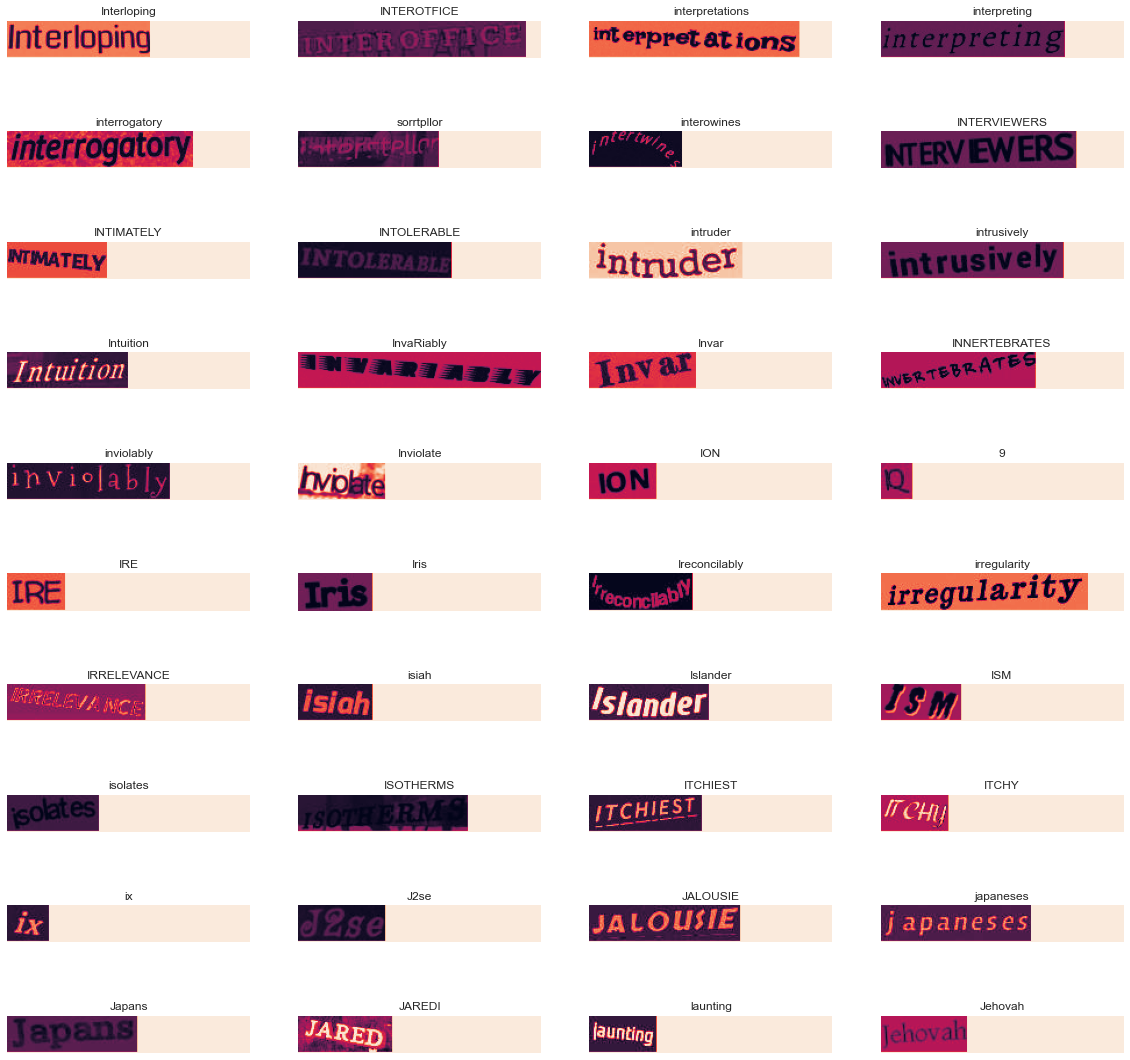

C:\Users\dsriaditya999\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\dsriaditya999\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Character Accuracy: 91.86
Word Accuracy: nan


In [ ]:
alphabet = """Only thewigsofrcvdampbkuq.$A-210xT5'MDL,RYHJ"ISPWENj&BC93VGFKz();#:!7U64Q8?+*ZX/%"""
args = {
    'name':'MLSP_Exp_2',
    'path':'/content/drive/MyDrive/MLSP_Project/Asish kumar Mishra/Work',
    'imgdir': 'IIT_5K',
    'imgH':32,
    'nChannels':1,
    'nHidden':256,
    'nClasses':len(alphabet),
    'lr':0.001,
    'epochs':6,
    'batch_size':64,
    'save_dir':'checkpoints',
    'log_dir':'logs',
    'resume':False,
    'cuda':False,
    'schedule':False,
    'device':device
    
}
model = CRNN(args)
args['collate_fn'] = SynthCollator()
args['alphabet'] = alphabet

args['data'] = SynthDataset(args)
resume_file = os.path.join(args['path'], args['name'], 'best_model.ckpt')
if os.path.isfile(resume_file):
    print('Loading model %s'%resume_file)
    checkpoint = torch.load(resume_file)
    model.load_state_dict(checkpoint['state_dict'])
    args['model'] = model
    ca, wa = get_accuracy(args)
    print("Character Accuracy: %.2f\nWord Accuracy: %.2f"%(ca, wa))
else:
    print("=> no checkpoint found at '{}'".format(save_file))
    print('Exiting')

  0%|          | 0/1563 [00:00<?, ?it/s]

Loading model checkpoints\MLSP_EXP_1\best_model.ckpt


100%|██████████| 1563/1563 [30:48<00:00,  1.18s/it]


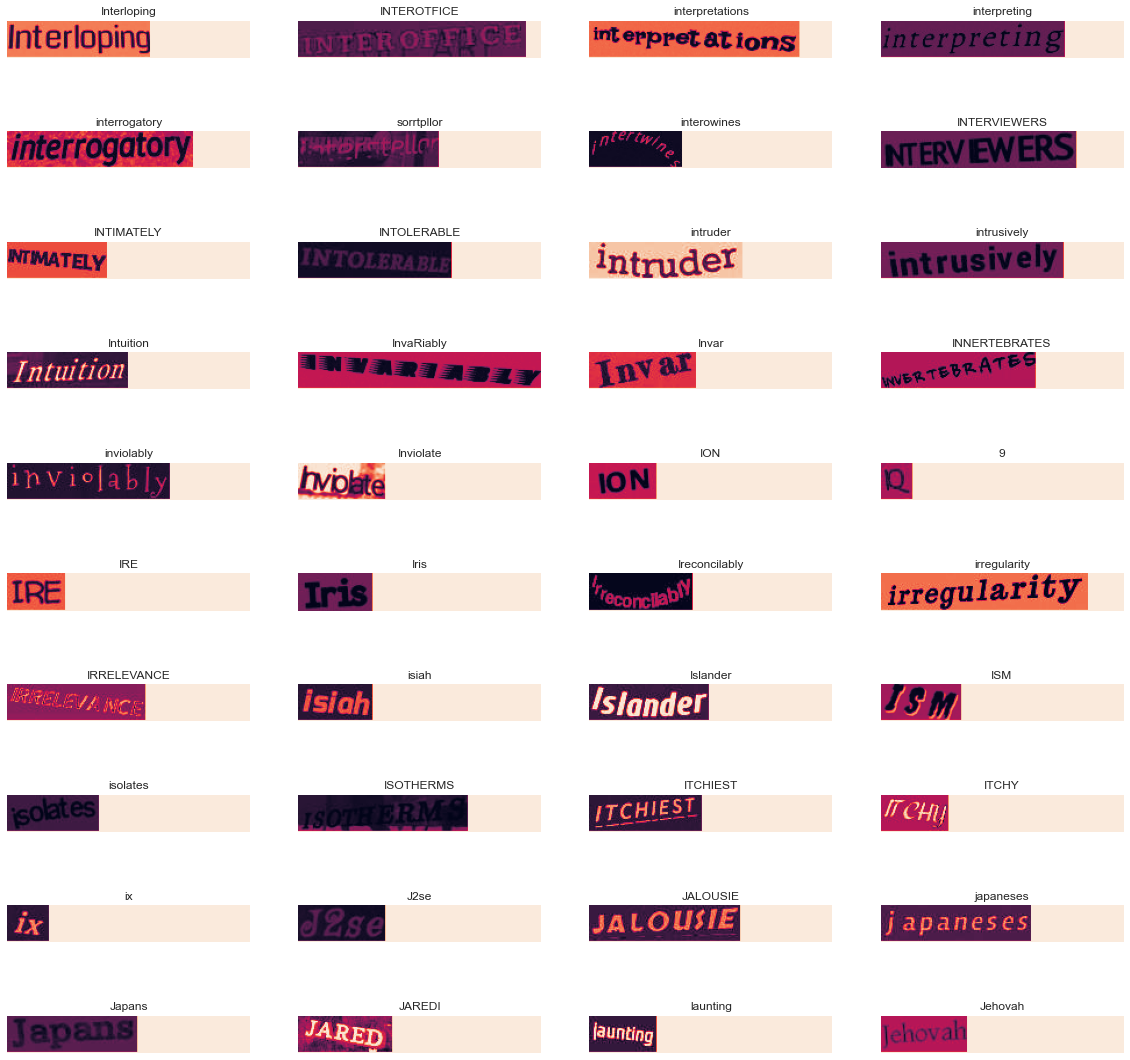

Character Accuracy: 91.86
Word Accuracy: nan


In [ ]:
args['imgdir'] = 'test_images'
args['data'] = SynthDataset(args)
resume_file = os.path.join(args['save_dir'], args['name'], 'best_model.ckpt')
if os.path.isfile(resume_file):
    print('Loading model %s'%resume_file)
    checkpoint = torch.load(resume_file)
    model.load_state_dict(checkpoint['state_dict'])
    args['model'] = model
    ca, wa = get_accuracy(args)
    print("Character Accuracy: %.2f\nWord Accuracy: %.2f"%(ca, wa))
else:
    print("=> no checkpoint found at '{}'".format(save_file))
    print('Exiting')

  0%|          | 0/149 [00:00<?, ?it/s]

Loading model checkpoints\MLSP_EXP_1\best_model.ckpt


100%|██████████| 149/149 [03:31<00:00,  1.42s/it]


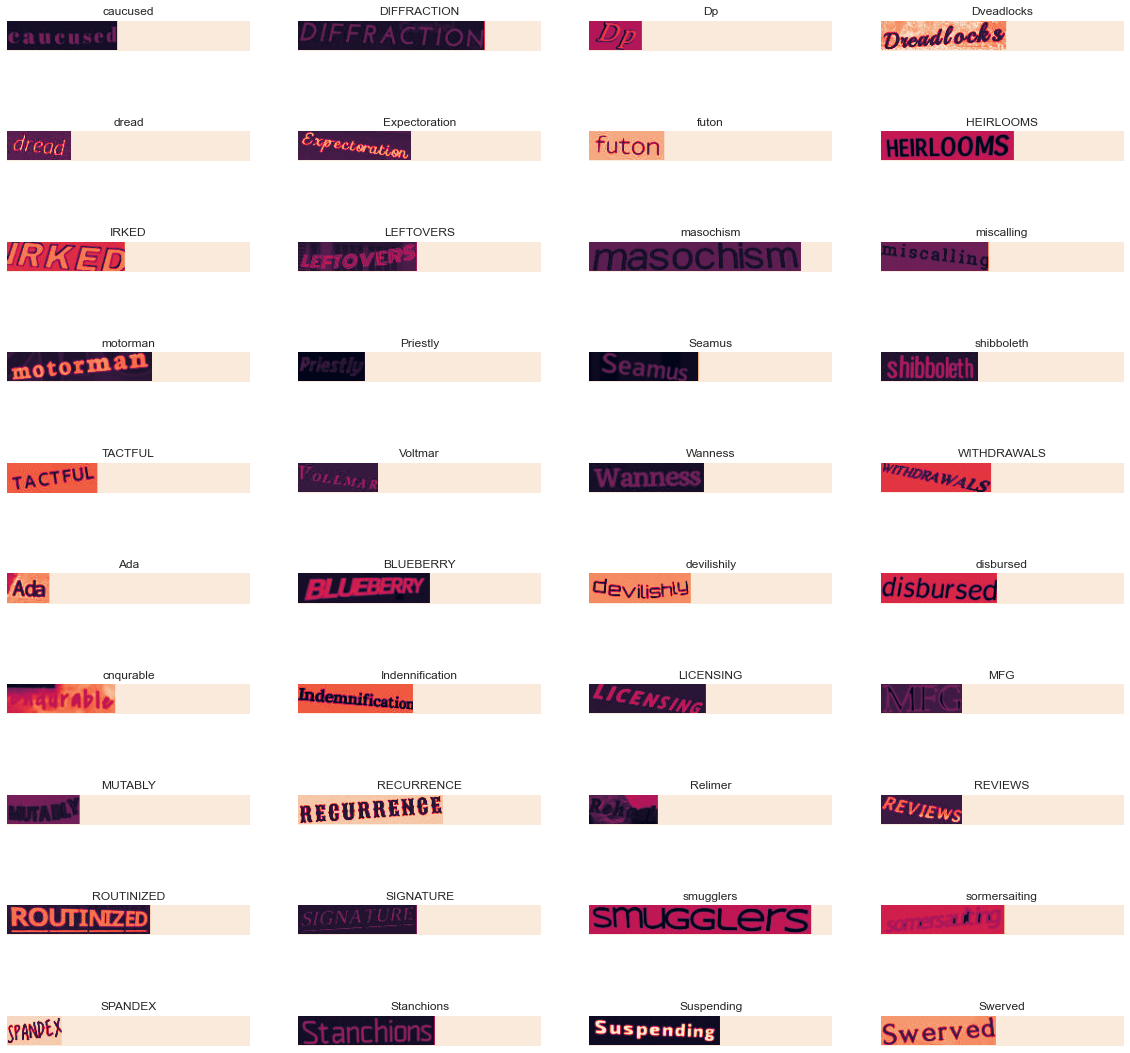

Character Accuracy: 92.72
Word Accuracy: 0.80


In [ ]:
args['path'] = 'data'
args['imgdir'] = 'test'
args['data'] = SynthDataset(args)
resume_file = os.path.join(args['save_dir'], args['name'], 'best_model.ckpt')
if os.path.isfile(resume_file):
    print('Loading model %s'%resume_file)
    checkpoint = torch.load(resume_file)
    model.load_state_dict(checkpoint['state_dict'])
    args['model'] = model
    ca, wa = get_accuracy(args)
    print("Character Accuracy: %.2f\nWord Accuracy: %.2f"%(ca, wa))
else:
    print("=> no checkpoint found at '{}'".format(save_file))
    print('Exiting')

In [28]:
transform_list =  [transforms.Resize((32)),
                           transforms.Grayscale(1),
                            transforms.ToTensor(), 
                            transforms.Normalize((0.5,), (0.5,))]
transform = transforms.Compose(transform_list)
img = Image.open("/content/3_4.png")
img1 = transform(img)

In [27]:
img1.size()

torch.Size([1, 45, 177])